# Plotting prototype v1 (real data)

In [1]:
from pathlib import Path
import yaml

# Paths
BASE = Path(".")
DATA = BASE / "data"
OUT  = BASE / "outputs"
DATA.mkdir(parents=True, exist_ok=True)
OUT.mkdir(parents=True, exist_ok=True)

# Required fields (always fill)
HEADER_REQUIRED = {
    "reference":  "Constraints on dark matter annihilation in dSphs from low-frequency radio",
    "doi":        "10.1103/PhysRevD.100.043002",   # or leave "" and set arxiv instead
    "instrument": "MWA",
    "year":       "2019",
    "source":     "Boo",
    "confidence": "0.95",
    "dmfraction": "1",
}

# Optional fields (may be empty).
# Use 'channel' ONLY if the figure truly has a SINGLE channel and WPD series names carry no channel info.
# Otherwise leave it empty; the writer will set channel per curve.
# 'quantity' defines the Y-axis physics: 'annihilation' (<sigma v>) or 'decay' (lifetime tau).
# 'x_unit_src'/'y_unit_src' are ORIGINAL axis units in the paper; the writer converts to GeV and cm^3/s (or s for decay).
HEADER_OPTIONAL = {
    "arxiv":         "",
    "journalref":    "Phys. Rev. D 100, 043002 (2019)",
    "url":           "",
    "collaboration": "",
    "obs_time":      "Phase I",
    "figure":        "Fig. 2 (top-left)",

    "channel":       "",                 # leave empty unless the figure has a single channel
    "quantity":      "annihilation",     # 'annihilation' (default) or 'decay'

    "x_unit_src":    "GeV",
    "y_unit_src":    "cm3 s-1",

    "comment":       "Radio limits with B=1 μG, D0=3e26 cm^2/s; solid: MWA; dashed/dotted: FL/CR.",
    "tags":          "radio, dSph, Boo",
    "status":        "done",
}

# Fixed key order for tidy ECSV meta (!!omap-like)
ORDER = [
    "reference","doi","arxiv","instrument","year","source","channel",
    "quantity",
    "confidence","dmfraction","obs_time","figure",
    "x_unit_src","y_unit_src",
    "journalref","url","collaboration","comment","tags","status"
]

def build_ordered_yaml(req: dict, opt: dict):
    merged = {k: "" for k in ORDER}
    merged.update(opt)
    merged.update(req)
    return [{k: merged[k]} for k in ORDER]

# Write header
yaml_path = DATA / "mwa_2019_boo_header.yaml"
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(build_ordered_yaml(HEADER_REQUIRED, HEADER_OPTIONAL),
              f, sort_keys=False, allow_unicode=True)

# Minimal sanity: require at least one of DOI/ArXiv
hdr = yaml.safe_load(yaml_path.read_text(encoding="utf-8"))
hdr_dict = {list(d)[0]: list(d.values())[0] for d in hdr}
if not (hdr_dict.get("doi") or hdr_dict.get("arxiv")):
    raise ValueError("Please provide at least one of: doi or arxiv.")

print(f"[OK] YAML header created: {yaml_path}")

[OK] YAML header created: data/mwa_2019_boo_header.yaml


In [2]:
# ==== JSON -> ECSV (standardized; canonical units enforced) for gDMbounds ====
# Canonical target units:
#   - DM mass: GeV
#   - For annihilation: <sigma v> in cm^3 / s  → column: sigmav
#   - For decay: lifetime in s                  → column: lifetime
#
# Pipeline:
#   1) Read YAML header (dict or list-of-pairs): quantity, x_unit_src, y_unit_src, channels (whitelist), series_map.
#   2) Read WebPlotDigitizer JSON (datasetColl/datasets; points as value[x,y] or x/y).
#   3) Convert to canonical units via astropy.units.
#   4) Resolve channel per curve: series_map → YAML 'channel' (override) → heuristics.
#   5) Write ECSV (float32, units, ordered meta), optional license banner.
#   6) Sanity checks, friendly warnings, final summary.

from __future__ import annotations
from pathlib import Path
import re, json, yaml
import numpy as np
from collections import Counter
from astropy.table import Table, Column
from astropy.io import ascii
from astropy import units as u

# -------- USER CONFIG --------
YAML_PATH = Path("data/mwa_2019_boo_header.yaml")  # <-- your YAML header
JSON_PATH = Path("data/figure2_topleft.json")      # <-- your WPD JSON
OUT_DIR   = Path("outputs")
ADD_LICENSE_BANNER       = False
STRICT_CHANNEL_WHITELIST = False   # if True and YAML 'channels' exists, skip curves not in that set
FAIL_FAST                = False   # if True, stop on first sanity error
# -----------------------------

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- tiny helpers ----------
def _warn(msg: str): print(f"⚠️  {msg}")
def _info(msg: str): print(f"• {msg}")

# ---------- YAML loader ----------
def load_meta_yaml(path: Path) -> dict:
    """Load YAML header: either dict or list of 1-key dicts → flat dict."""
    obj = yaml.safe_load(path.read_text(encoding="utf-8"))
    if isinstance(obj, list):
        meta = {}
        for item in obj:
            if isinstance(item, dict) and item:
                k, v = next(iter(item.items()))
                meta[k] = v
        return meta
    if isinstance(obj, dict):
        return obj
    raise ValueError("Unsupported YAML structure")

def _normalize_name(s: str) -> str:
    # Normalize Greek letters / glyphs for robust tokenization
    return (s.replace("τ", "tau")
             .replace("μ", "mu")
             .replace("γ", "gamma")
             .replace("−", "-"))

def _tokens(name: str):
    name = _normalize_name(name).lower()
    return [t for t in re.split(r"[^a-z0-9]+", name) if t]

# ---------- channel / tag resolvers ----------
def _canon_channel(ch: str) -> str:
    """Return canonical case (WW/ZZ/Zg keep caps). Others lower-case."""
    ch = (ch or "").strip()
    low = ch.lower()
    if low == "ww": return "WW"
    if low == "zz": return "ZZ"
    if low in {"zg","zγ","zgamma","gammaz","z-gamma","z_gamma"}: return "Zg"
    return low  # bb, cc, tt, qq, ee, mumu, tautau, hh, gg, gammagamma, nunu

def resolve_channel_from_name(name: str) -> str|None:
    """
    Robust channel resolver with many synonyms.
    Returns canonical channel: bb, cc, tt, qq, ee, mumu, tautau, WW, ZZ, hh, gg,
                               gammagamma, Zg, nunu
    """
    s = (name or "").lower()
    s = (s.replace("τ", "tau").replace("μ", "mu")
           .replace("γ", "gamma").replace("−","-"))

    toks = [t for t in re.split(r"[^a-z0-9]+", s) if t]
    def count(tok): return toks.count(tok)

    # quarks & leptons
    if "bb" in toks or "bbar" in toks: return "bb"
    if "cc" in toks or "charm" in toks: return "cc"
    if "tt" in toks or "top" in toks: return "tt"
    if "ee" in toks or "e+e-" in s: return "ee"
    if "mumu" in toks or ("mu" in toks and count("mu") >= 2): return "mumu"
    if "tautau" in toks or count("tau") >= 2: return "tautau"

    # bosons
    if "ww" in toks or "w+w-" in s: return "WW"
    if "zz" in toks or "z z" in s:  return "ZZ"
    if "hh" in toks or "higgs" in toks: return "hh"
    if "gg" in toks or "gluon" in toks: return "gg"

    # photons / mixed
    if "gammagamma" in toks or "2gamma" in toks or "line" in toks or count("gamma") >= 2:
        return "gammagamma"
    if "zg" in toks or "zgamma" in toks or "gamma z" in s or "z-gamma" in s:
        return "Zg"

    # neutrinos / light quarks
    if "nunu" in toks or ("nu" in toks and count("nu") >= 2): return "nunu"
    if any(q in toks for q in ["qq","uu","dd","ss","light","lightquarks"]): return "qq"

    return None

def resolve_tag(name: str) -> str|None:
    """Resolve comparison/source tag (FL/CR/instrument) from series name."""
    toks = _tokens(name)
    if "fl" in toks or "fermi" in toks or "lat" in toks: return "FL"
    if "cr" in toks or "cosmic" in toks or "rays" in toks or "ray" in toks: return "CR"
    for inst in ["mwa","lofar","magic","hawc","hess","cta","veritas","lhaaso","lat"]:
        if inst in toks:
            return "FL" if inst in ("lat","fermi") else inst.upper()
    return None

# ---------- WebPlotDigitizer series iterator ----------
def iter_series_from_wpd(wpd: dict):
    """
    Yield (series_name, xs, ys) from WebPlotDigitizer JSON.
    Supports 'datasetColl' or 'datasets'; points with 'value':[x,y] or 'x','y'.
    """
    if "datasetColl" in wpd and isinstance(wpd["datasetColl"], list):
        series_list = wpd["datasetColl"]
    elif "datasets" in wpd and isinstance(wpd["datasets"], list):
        series_list = wpd["datasets"]
    else:
        series_list = wpd.get("series", [])
        if not isinstance(series_list, list):
            raise ValueError("No series found in JSON (datasetColl/datasets/series missing)")

    for s in series_list:
        name = str(s.get("name","")).strip()
        pts  = s.get("data") or s.get("points") or s.get("series") or []
        xs, ys = [], []
        for p in pts:
            if isinstance(p, dict):
                if "value" in p and isinstance(p["value"], (list, tuple)) and len(p["value"])>=2:
                    x, y = p["value"][0], p["value"][1]
                else:
                    x, y = p.get("x"), p.get("y")
            elif isinstance(p, (list, tuple)) and len(p)>=2:
                x, y = p[0], p[1]
            else:
                continue
            if x is None or y is None:
                continue
            try:
                xs.append(float(x)); ys.append(float(y))
            except Exception:
                _warn(f"Non-numeric point in series {name!r} skipped")
        if xs and ys:
            yield name, np.asarray(xs, float), np.asarray(ys, float)

# ---------- cleaning ----------
def clean_series(x: np.ndarray, y: np.ndarray):
    """Finite, positive, sorted by x, drop exact duplicate x; cast to float32."""
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x2, y2 = x[mask], y[mask]
    if x2.size == 0:
        return x2.astype("float32"), y2.astype("float32")
    order = np.argsort(x2)
    x2, y2 = x2[order], y2[order]
    uniq = np.concatenate(([0], np.where(np.diff(x2) != 0)[0] + 1))
    return x2[uniq].astype("float32"), y2[uniq].astype("float32")

def sanitize_name(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

# ---------- units: parsing + conversion ----------
def parse_unit(s: str|None, default_unit):
    """Parse unit string via astropy; tolerate common spellings; fall back to default if empty."""
    if not s or str(s).strip() == "":
        return default_unit
    try:
        return u.Unit(s)
    except Exception:
        s2 = (s.replace("^", "**")
               .replace("cm^3 s^-1", "cm3/s")
               .replace("cm3 s-1",  "cm3/s")
               .replace("m^3 s^-1", "m3/s")
               .replace("m3 s-1",   "m3/s")
               .replace(" sec", " s").replace("second", "s").replace("seconds", "s")
               .strip())
        return u.Unit(s2)

def to_unit(values: np.ndarray, src_unit, dst_unit):
    """Convert numeric array from src_unit to dst_unit if src_unit is known; else pass-through."""
    if src_unit is None:
        return np.asarray(values, float)
    q = np.asarray(values, float) * src_unit
    return q.to(dst_unit).value

def unit_hints(x, ux, y, uy, quantity: str):
    """Non-fatal hints if magnitudes look suspicious."""
    try:
        xmax = float(np.nanmax(x))
        ymax = float(np.nanmax(y))
    except Exception:
        return
    if ux.is_equivalent(u.GeV) and xmax < 1e-3:
        _warn("x max < 1e-3 GeV — figure might be in TeV/MeV; check x_unit_src in YAML.")
    if ux.is_equivalent(u.GeV) and xmax > 1e8:
        _warn("x max > 1e8 GeV — check axis calibration / x_unit_src.")
    if quantity == "annihilation":
        if uy.is_equivalent(u.cm**3/u.s) and not (1e-34 <= ymax <= 1e-20):
            _warn("y max far from typical <sigma v> range (cm^3/s) — check y_unit_src in YAML.")
    else:  # decay
        if uy.is_equivalent(u.s) and not (1e15 <= ymax <= 1e35):
            _warn("y max looks unusual for decay lifetimes (s) — check y_unit_src in YAML.")

# ---------- ECSV checks / banner ----------
def ecsv_sanity_check(path: Path, quantity: str, want_channel: str|None = None):
    """Validate ECSV columns/units/dtypes/meta and basic data sanity."""
    try:
        t = ascii.read(path, format="ecsv")
    except Exception as e:
        raise RuntimeError(f"Failed to read ECSV {path.name}: {e}")

    if quantity == "annihilation":
        col = "sigmav"
        assert "mass" in t.colnames and col in t.colnames, "ECSV: columns missing"
        assert t["mass"].unit.is_equivalent(u.GeV), f"mass unit {t['mass'].unit}"
        assert t[col].unit.is_equivalent((u.cm**3)/u.s), f"{col} unit {t[col].unit}"
        assert np.dtype(t["mass"].dtype) == np.float32, f"mass dtype {t['mass'].dtype}"
        assert np.dtype(t[col].dtype) == np.float32, f"{col} dtype {t[col].dtype}"
    else:
        col = "lifetime"
        assert "mass" in t.colnames and col in t.colnames, "ECSV: columns missing"
        assert t["mass"].unit.is_equivalent(u.GeV), f"mass unit {t['mass'].unit}"
        assert t[col].unit.is_equivalent(u.s), f"{col} unit {t[col].unit}"
        assert np.dtype(t["mass"].dtype) == np.float32, f"mass dtype {t['mass'].dtype}"
        assert np.dtype(t[col].dtype) == np.float32, f"{col} dtype {t[col].dtype}"

    meta = t.meta or {}
    for k in ["reference","instrument","year","source","confidence","dmfraction","channel","quantity"]:
        assert k in meta and str(meta[k]).strip() != "", f"meta[{k}] missing/empty"

    if want_channel:
        assert _canon_channel(meta.get("channel","")) == _canon_channel(want_channel), f"meta[channel]!={want_channel}"

    assert np.all(np.isfinite(t["mass"])) and np.all(t["mass"] > 0), "mass has non-finite or non-positive values"
    assert np.all(np.isfinite(t[col])) and np.all(t[col] > 0), f"{col} has non-finite or non-positive values"
    return t

def maybe_prepend_license(path: Path):
    if not ADD_LICENSE_BANNER:
        return
    text = path.read_text(encoding="utf-8")
    if "Part of https://github.com/micheledoro/gDMbounds/" in text:
        return
    banner = (
        "# %Part of https://github.com/micheledoro/gDMbounds/ under the\n"
        "# %Creative Commons Attribution-NonCommercial-ShareAlike 3.0 Unported License, see LICENSE.rst\n"
    )
    lines = text.splitlines(True)
    if lines and lines[0].startswith("# %ECSV"):
        new_text = lines[0] + banner + "".join(lines[1:])
    else:
        new_text = banner + text
    path.write_text(new_text, encoding="utf-8")

# ---------- load inputs & validate YAML ----------
assert YAML_PATH.exists(), f"YAML not found: {YAML_PATH}"
assert JSON_PATH.exists(), f"JSON not found: {JSON_PATH}"

meta = load_meta_yaml(YAML_PATH)
for k in ["reference","instrument","year","source","confidence","dmfraction"]:
    if not (k in meta and str(meta[k]).strip()):
        raise ValueError(f"YAML meta missing/empty: {k}")

quantity = (meta.get("quantity") or "annihilation").strip().lower()
if quantity not in {"annihilation","decay"}:
    raise ValueError(f"Unsupported 'quantity' in YAML: {quantity!r}. Use 'annihilation' or 'decay'.")

# units from YAML (default to canonical)
x_unit_src = parse_unit(meta.get("x_unit_src"), u.GeV)
y_unit_src = parse_unit(meta.get("y_unit_src"),
                        (u.cm**3)/u.s if quantity=="annihilation" else u.s)

# channels whitelist (optional)
channels_whitelist = set()
if isinstance(meta.get("channels"), (list, tuple)):
    channels_whitelist = { _canon_channel(str(c)) for c in meta["channels"] if str(c).strip() }

# series_map (optional) — case-insensitive exact match table
series_map = meta.get("series_map") or {}
series_map_norm = { _normalize_name(k): v for k,v in series_map.items() } if isinstance(series_map, dict) else {}

# ---------- load WPD & pre-warnings ----------
try:
    wpd = json.loads(JSON_PATH.read_text(encoding="utf-8"))
except Exception as e:
    raise RuntimeError(f"Cannot parse JSON {JSON_PATH.name}: {e}")

series_cache = list(iter_series_from_wpd(wpd))

ch_yaml = (meta.get("channel") or "").strip()
if ch_yaml and len(series_cache) > 1 and not series_map_norm:
    _warn("YAML has 'channel' set while multiple series are present and no 'series_map' is provided; "
          "the SAME channel will be applied to all curves. If this is not intended, "
          "clear 'channel' in YAML or define 'series_map'.")

if ch_yaml and channels_whitelist and _canon_channel(ch_yaml) not in channels_whitelist:
    _warn(f"YAML 'channel'={ch_yaml!r} is not in YAML 'channels' whitelist {sorted(channels_whitelist)}.")

# ---------- process series ----------
counters = {}   # per (channel, tag) for unique filenames
written  = []
skips    = Counter()

for name, xs, ys in series_cache:
    # 1) series_map (bullet-proof)
    mapped = series_map_norm.get(_normalize_name(name))
    ch, tag = None, None
    if isinstance(mapped, dict):
        ch  = mapped.get("channel")
        tag = mapped.get("tag")

    # 2) YAML channel override (applies to all curves) if not set by map
    if ch is None:
        ch = ch_yaml if ch_yaml else resolve_channel_from_name(name)

    # 3) tag from name or fall back to instrument
    if tag is None:
        tag = resolve_tag(name) or meta.get("instrument","") or "curve"

    # channel validation
    if ch is None or str(ch).strip() == "":
        _warn(f"Skip (channel unresolved): {name!r}")
        skips["channel_unresolved"] += 1
        continue
    ch = _canon_channel(ch)
    if channels_whitelist and ch not in channels_whitelist:
        msg = f"Skip (channel '{ch}' not in YAML channels whitelist {sorted(channels_whitelist)}): {name!r}"
        if STRICT_CHANNEL_WHITELIST:
            _warn(msg)
            skips["not_in_whitelist"] += 1
            continue
        else:
            _warn(msg + " — proceeding (STRICT_CHANNEL_WHITELIST=False)")

    # clean points
    X_raw, Y_raw = clean_series(xs, ys)
    if X_raw.size == 0:
        _warn(f"Skip (no valid points): {name!r}")
        skips["no_points"] += 1
        continue

    # convert to canonical units
    try:
        X = to_unit(X_raw, x_unit_src, u.GeV)
        if quantity == "annihilation":
            Y = to_unit(Y_raw, y_unit_src, (u.cm**3)/u.s)
        else:
            Y = to_unit(Y_raw, y_unit_src, u.s)
    except Exception as e:
        _warn(f"Skip (unit conversion failed for {name!r}): {e}")
        skips["unit_conversion_failed"] += 1
        continue

    # gentle hints
    unit_hints(X, u.GeV, Y, (u.cm**3)/u.s if quantity=="annihilation" else u.s, quantity)

    # --- build table with correct Y column depending on quantity ---
    t = Table()
    t["mass"] = Column(X, unit=u.GeV, dtype="float32", description="DM mass")

    if quantity == "decay":
        y_name, y_unit, y_desc = "lifetime", u.s, "DM decay lifetime tau"
    else:
        y_name, y_unit, y_desc = "sigmav", (u.cm**3)/u.s, "<sigma v>"

    t[y_name] = Column(Y, unit=y_unit, dtype="float32", description=y_desc)

    # per-curve meta
    m = dict(meta)
    m["channel"]  = ch
    m["tag"]      = tag
    m["quantity"] = quantity  # ensure present in meta for checks/plotting
    t.meta = m

    # unique filename
    inst  = sanitize_name(meta.get("instrument",""))
    year  = sanitize_name(meta.get("year",""))
    src   = sanitize_name(meta.get("source",""))
    ch_s  = sanitize_name(ch)
    tag_s = sanitize_name(tag)
    counters[(ch_s, tag_s)] = counters.get((ch_s, tag_s), 0) + 1
    suffix = "" if counters[(ch_s, tag_s)] == 1 else f"_v{counters[(ch_s, tag_s)]}"

    fname = f"{inst}_{year}_{src}_{ch_s}_{tag_s}{suffix}.ecsv"
    out_path = OUT_DIR / fname
    ascii.write(t, out_path, format="ecsv", overwrite=True)
    maybe_prepend_license(out_path)

    # sanity check (friendly failure)
    try:
        ecsv_sanity_check(out_path, quantity=quantity, want_channel=ch)
    except AssertionError as e:
        msg = f"Sanity check failed for {fname}: {e}"
        if FAIL_FAST:
            raise AssertionError(msg)
        _warn(msg)
        skips["sanity_failed"] += 1
        written.append(fname + "  (sanity:FAIL)")
        continue

    written.append(fname)
    _info(f"Wrote {fname}  ({len(X)} pts; channel={ch}, tag={tag}, series={name!r})")

# ---------- final summary ----------
print("\n=== Summary ===")
print(f"YAML: {YAML_PATH.name} | JSON: {JSON_PATH.name} | quantity: {quantity}")
if written:
    print("Written files:")
    for w in written:
        print(" -", w)
else:
    print("No ECSV files written.")

if not written and not skips and not (meta.get('channel') or '').strip() and not series_map_norm:
    _warn("No curves written and no explicit errors; no channels recognized. "
          "Ensure series names contain channel tokens (bb/tautau/WW/...) or provide 'series_map' in YAML.")

if skips:
    print("Skipped series by reason:")
    for reason, cnt in skips.items():
        print(f" - {reason}: {cnt}")

• Wrote mwa_2019_boo_bb_fl.ecsv  (47 pts; channel=bb, tag=FL, series='FL_bb')
• Wrote mwa_2019_boo_tautau_fl.ecsv  (48 pts; channel=tautau, tag=FL, series='FL_tautau')
• Wrote mwa_2019_boo_bb_cr.ecsv  (24 pts; channel=bb, tag=CR, series='CR_bb')
• Wrote mwa_2019_boo_tautau_cr.ecsv  (24 pts; channel=tautau, tag=CR, series='CR_tautau')

=== Summary ===
YAML: mwa_2019_boo_header.yaml | JSON: figure2_topleft.json | quantity: annihilation
Written files:
 - mwa_2019_boo_bb_fl.ecsv
 - mwa_2019_boo_tautau_fl.ecsv
 - mwa_2019_boo_bb_cr.ecsv
 - mwa_2019_boo_tautau_cr.ecsv


In [4]:
# ==== Plot limits from many ECSV files (robust & user-friendly) ====
from pathlib import Path
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import Iterable, List, Dict, Any

# ----------------------- Path resolving -----------------------
def _resolve_inputs(ecsv_inputs: Iterable[str|Path]) -> List[Path]:
    """
    Accept paths, folders, and glob patterns. Return a flat list of .ecsv files.
    Examples:
      ["outputs/*.ecsv", "other/run1", "one/file.ecsv"]
    """
    files: List[Path] = []
    for inp in ecsv_inputs:
        p = Path(inp)
        if any(ch in str(p) for ch in ["*", "?", "["]):  # glob pattern
            files.extend([Path(f) for f in p.parent.glob(p.name) if str(f).endswith(".ecsv")])
        elif p.is_dir():
            files.extend([f for f in p.rglob("*.ecsv")])
        elif p.is_file() and str(p).endswith(".ecsv"):
            files.append(p)
        else:
            print(f"⚠️  Skipping input (not found or not .ecsv): {p}")
    # unique & stable order
    files = sorted(set(files))
    if not files:
        raise FileNotFoundError("No .ecsv files resolved from inputs.")
    return files

# ----------------------- Column picking -----------------------
def _pick_column(tab: Table, candidates: List[str]) -> str:
    """Return the first column name from candidates that exists in the table."""
    for name in candidates:
        if name in tab.colnames:
            return name
    raise KeyError(f"None of {candidates} found. Available: {tab.colnames}")

def _canon_quantity_from_table(tab: Table, meta: Dict[str, Any]) -> str:
    """
    Decide 'annihilation' vs 'decay' using meta['quantity'] when present,
    otherwise by column presence.
    """
    q = (meta.get("quantity") or "").strip().lower()
    if q in {"annihilation", "decay"}:
        return q
    if "sigmav" in tab.colnames or "sigma_v" in tab.colnames:
        return "annihilation"
    if "lifetime" in tab.colnames or "tau" in tab.colnames or "decay_tau" in tab.colnames:
        return "decay"
    # default to annihilation, but warn
    print("⚠️  quantity not specified; defaulting to 'annihilation'.")
    return "annihilation"

# ----------------------- Unit conversion helpers -----------------------
def _to_unit(values, unit_obj, target_unit: u.UnitBase):
    """Convert numeric array to target_unit when unit_obj is present."""
    arr = np.asarray(values, float)
    if unit_obj is None:
        return arr
    try:
        return (arr * u.Unit(unit_obj)).to(target_unit).value
    except Exception:
        # if unit_obj is string-like but odd (e.g., "cm3 s-1")
        try:
            unit_norm = str(unit_obj).replace("^", "**").replace("cm3 s-1", "cm3/s").replace("m3 s-1","m3/s")
            return (arr * u.Unit(unit_norm)).to(target_unit).value
        except Exception as e:
            print(f"⚠️  Unit conversion failed ({unit_obj} -> {target_unit}): {e}; using raw numbers.")
            return arr

def _fmt_unit(unit_obj, fallback: str) -> str:
    return str(unit_obj) if unit_obj else fallback

# ----------------------- Label & style helpers -----------------------
def _label_from_meta(meta: Dict[str, Any]) -> str:
    """
    Compose a compact, readable label like:
      'MWA 2019 (Boo, bb) [FL]'
    """
    if meta.get("label"):
        return str(meta["label"])
    exp  = meta.get("instrument", meta.get("experiment", "?"))
    year = meta.get("year", "?")
    src  = meta.get("source", meta.get("target", "?"))
    ch   = meta.get("channel", "?")
    tag  = meta.get("tag", "")
    tag_sfx = f" [{tag}]" if tag else ""
    return f"{exp} {year} ({src}, {ch}){tag_sfx}"

def _linestyle_from_tag(tag: str|None) -> str:
    """
    Light visual cue: FL → dashed, CR → dotted, else solid.
    """
    t = (tag or "").upper()
    if t == "FL":
        return "--"
    if t == "CR":
        return ":"
    return "-"

# ----------------------- Curve loader -----------------------
def load_curve_from_ecsv(ecsv_path: Path) -> Dict[str, Any]:
    """
    Read one ECSV file and return a dict with:
      - x, y: numpy arrays (sorted by x; positives only; duplicates dropped)
      - xunit, yunit: strings for axis labels
      - quantity: 'annihilation' or 'decay'
      - label: string for legend
      - style: dict with matplotlib kwargs (currently 'linestyle')
      - path: original Path (for debugging)
    """
    tab = Table.read(ecsv_path, format="ascii.ecsv")
    meta = tab.meta or {}
    quantity = _canon_quantity_from_table(tab, meta)

    # Column selection
    xcol = _pick_column(tab, ["mass", "m", "dm_mass"])
    if quantity == "annihilation":
        ycol = _pick_column(tab, ["sigmav", "sigma_v", "sigmav_ul", "sigma_v_ul"])
        y_target = (u.cm**3)/u.s
    else:
        ycol = _pick_column(tab, ["lifetime", "tau", "decay_tau"])
        y_target = u.s

    # Units
    xunit_obj = getattr(tab[xcol], "unit", None)
    yunit_obj = getattr(tab[ycol], "unit", None)

    # Convert to canonical units (GeV; cm^3/s or s)
    x = _to_unit(tab[xcol], xunit_obj, u.GeV)
    y = _to_unit(tab[ycol], yunit_obj, y_target)

    # Clean: finite, positive, sorted by x, drop exact duplicate x
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x, y = x[mask], y[mask]
    if x.size == 0:
        raise ValueError(f"No valid (positive, finite) points in {ecsv_path.name}")
    order = np.argsort(x)
    x, y = x[order], y[order]
    uniq = np.concatenate(([0], np.where(np.diff(x) != 0)[0] + 1))
    x, y = x[uniq].astype("float32"), y[uniq].astype("float32")

    # Labels & style
    label = _label_from_meta(meta)
    style = {"linestyle": _linestyle_from_tag(meta.get("tag"))}

    return {
        "x": x,
        "y": y,
        "xunit": _fmt_unit(xunit_obj, "GeV"),
        "yunit": _fmt_unit(yunit_obj, "cm^3 s^-1" if quantity=="annihilation" else "s"),
        "quantity": quantity,
        "label": label,
        "style": style,
        "path": ecsv_path,
    }

# ----------------------- Plotting -----------------------
def _plot_group(curves: List[Dict[str, Any]], out_png: Path|None, out_pdf: Path|None, title: str|None):
    """
    Plot a group of curves that share the same quantity (annihilation OR decay).
    """
    if not curves:
        return

    quantity = curves[0]["quantity"]
    # Axis labels
    xlab = "DM mass [GeV]"  # after conversion
    if quantity == "annihilation":
        ylab = r"$\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]"
    else:
        ylab = r"DM decay lifetime $\tau$ [s]"

    plt.figure(figsize=(7.2, 4.8))
    for c in curves:
        # log–log for both annihilation and decay
        plt.loglog(c["x"], c["y"], linewidth=1.8, label=c["label"], **c["style"])

    # Labels / title
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if title:
        # add suffix showing the quantity plotted
        plt.title(f"{title} — {quantity}")

    # Grid & legend
    plt.grid(True, which="both", alpha=0.25)
    # Place legend outside if many curves
    if len(curves) > 8:
        plt.legend(fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
        plt.tight_layout(rect=[0, 0, 0.82, 1])
    else:
        plt.legend(fontsize=9)
        plt.tight_layout()

    # Save
    if out_png:
        out_png.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_png, dpi=220)
    if out_pdf:
        out_pdf.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_pdf)
    plt.show()
    plt.close()
    
    if out_png or out_pdf:
        msg = "Saved:"
        if out_png: msg += f" {out_png}"
        if out_pdf: msg += f" and {out_pdf}"
        print(msg)

def plot_ecsv_many(
    ecsv_inputs: Iterable[str|Path],
    out_base: str|Path|None = None,
    title: str|None = None,
):
    """
    Plot all curves from the given ECSV inputs.
    - ecsv_inputs: files/folders/globs (any mix). All .ecsv found will be plotted.
    - out_base: optional output base path (e.g., 'outputs/overlay'). Two files may be produced:
        {out_base}_annihilation.png and/or {out_base}_decay.png (and similarly for .pdf if desired).
      If None, figures are just shown and not saved.
    - title: optional figure title prefix (we add '— annihilation' / '— decay').

    Returns: dict with keys 'annihilation' and/or 'decay' listing the files that were plotted.
    """
    files = _resolve_inputs(ecsv_inputs)

    curves = []
    skipped = 0
    for f in files:
        try:
            curves.append(load_curve_from_ecsv(Path(f)))
        except Exception as e:
            print(f"⚠️  Skipping {Path(f).name}: {e}")
            skipped += 1

    if not curves:
        raise RuntimeError("No curves loaded successfully. Check inputs.")

    # Group by quantity
    by_q: Dict[str, List[Dict[str, Any]]] = {"annihilation": [], "decay": []}
    for c in curves:
        by_q[c["quantity"]].append(c)

    # Build output names if requested
    outs = {}
    if out_base is not None:
        base = Path(out_base)
        outs["annihilation_png"] = base.with_name(base.name + "_annihilation.png")
        outs["decay_png"]        = base.with_name(base.name + "_decay.png")
        # You can also add PDF siblings by changing below lines:
        outs["annihilation_pdf"] = None
        outs["decay_pdf"]        = None
    else:
        outs = {"annihilation_png": None, "decay_png": None, "annihilation_pdf": None, "decay_pdf": None}

    # Plot groups
    result = {}
    if by_q["annihilation"]:
        _plot_group(by_q["annihilation"], outs["annihilation_png"], outs["annihilation_pdf"], title)
        result["annihilation"] = [c["path"] for c in by_q["annihilation"]]
    if by_q["decay"]:
        _plot_group(by_q["decay"], outs["decay_png"], outs["decay_pdf"], title)
        result["decay"] = [c["path"] for c in by_q["decay"]]

    # Final summary
    print("\n=== Plot summary ===")
    print(f"Total input files: {len(files)}; loaded: {len(curves)}; skipped: {skipped}")
    for q in ("annihilation", "decay"):
        if q in result:
            print(f" - {q}: {len(result[q])} curves")

    return result

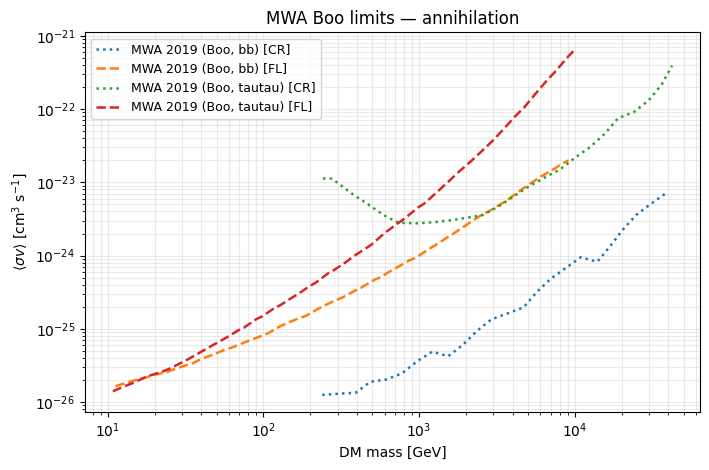

Saved: outputs/mwa_2019_boo_overlay_annihilation.png

=== Plot summary ===
Total input files: 4; loaded: 4; skipped: 0
 - annihilation: 4 curves


{'annihilation': [PosixPath('outputs/mwa_2019_boo_bb_cr.ecsv'),
  PosixPath('outputs/mwa_2019_boo_bb_fl.ecsv'),
  PosixPath('outputs/mwa_2019_boo_tautau_cr.ecsv'),
  PosixPath('outputs/mwa_2019_boo_tautau_fl.ecsv')]}

In [5]:
# === Plot the four Boo curves from outputs/ ===
from pathlib import Path

# Ensure plotting helper is defined
try:
    plot_ecsv_many
except NameError:
    raise RuntimeError("Please run the previous cell that defines plot_ecsv_many(...) first.")

OUT = Path("outputs")

expected_files = [
    "mwa_2019_boo_bb_cr.ecsv",
    "mwa_2019_boo_bb_fl.ecsv",
    "mwa_2019_boo_tautau_cr.ecsv",
    "mwa_2019_boo_tautau_fl.ecsv",
]

files = [OUT / f for f in expected_files if (OUT / f).exists()]
missing = [f for f in expected_files if not (OUT / f).exists()]

if missing:
    print("⚠️ Missing files in outputs/:", ", ".join(missing))
if not files:
    raise FileNotFoundError("None of the expected ECSV files were found in outputs/.")

# Plot and save
result = plot_ecsv_many(
    files,
    out_base=OUT / "mwa_2019_boo_overlay",
    title="MWA Boo limits",
)
result

⚠️  Skipping lat_2016_multidsph_dec_bb.ecsv: unable to parse yaml in meta header
⚠️  Skipping lat_2023_multidsph_ann_bb_benchmark.ecsv: unable to parse yaml in meta header
⚠️  Skipping lat_2023_multidsph_ann_bb_measured.ecsv: unable to parse yaml in meta header
⚠️  Skipping lat_2023_multidsph_ann_tautau_benchmark.ecsv: unable to parse yaml in meta header
⚠️  Skipping lat_2023_multidsph_ann_tautau_measured.ecsv: unable to parse yaml in meta header
⚠️  Skipping lat_2023_sagittarius_ann_bb.ecsv: ECSV header line like "# %ECSV <version>" not found as first line.  This is required for a ECSV file.


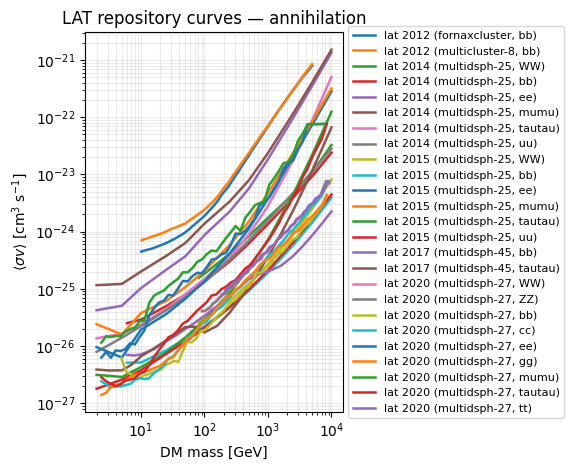

Saved: outputs/lat_overlay_annihilation.png


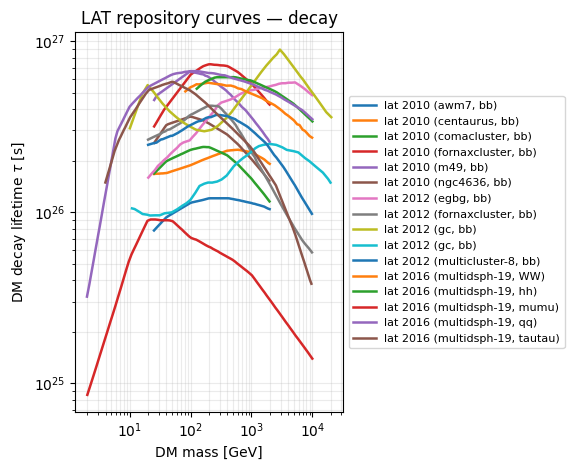

Saved: outputs/lat_overlay_decay.png

=== Plot summary ===
Total input files: 47; loaded: 41; skipped: 6
 - annihilation: 25 curves
 - decay: 16 curves


{'annihilation': [PosixPath('outputs/lat/lat_2012_fornaxcluster_ann_bb.ecsv'),
  PosixPath('outputs/lat/lat_2012_multicluster_ann_bb.ecsv'),
  PosixPath('outputs/lat/lat_2014_multidsph_ann_WW.ecsv'),
  PosixPath('outputs/lat/lat_2014_multidsph_ann_bb.ecsv'),
  PosixPath('outputs/lat/lat_2014_multidsph_ann_ee.ecsv'),
  PosixPath('outputs/lat/lat_2014_multidsph_ann_mumu.ecsv'),
  PosixPath('outputs/lat/lat_2014_multidsph_ann_tautau.ecsv'),
  PosixPath('outputs/lat/lat_2014_multidsph_ann_uu.ecsv'),
  PosixPath('outputs/lat/lat_2015_multidsph_ann_WW.ecsv'),
  PosixPath('outputs/lat/lat_2015_multidsph_ann_bb.ecsv'),
  PosixPath('outputs/lat/lat_2015_multidsph_ann_ee.ecsv'),
  PosixPath('outputs/lat/lat_2015_multidsph_ann_mumu.ecsv'),
  PosixPath('outputs/lat/lat_2015_multidsph_ann_tautau.ecsv'),
  PosixPath('outputs/lat/lat_2015_multidsph_ann_uu.ecsv'),
  PosixPath('outputs/lat/lat_2017_multidsph_ann_bb.ecsv'),
  PosixPath('outputs/lat/lat_2017_multidsph_ann_tautau.ecsv'),
  PosixPath('outp

In [6]:
# === Plot all curves from outputs/lat (repo ECSV) ===
from pathlib import Path

# ensure plotting helper is defined
try:
    plot_ecsv_many
except NameError:
    raise RuntimeError("Please run the previous cell that defines plot_ecsv_many(...) first.")

# prefer outputs/lat; tolerate outputs/LAT just in case
candidates = [Path("outputs/lat"), Path("outputs/LAT")]
base_dir = next((p for p in candidates if p.exists() and p.is_dir()), None)
if base_dir is None:
    raise FileNotFoundError(
        "Couldn't find 'outputs/lat' folder. "
        "Make sure you've copied the repo ECSV files into outputs/lat."
    )

# plot everything inside that folder (recursively)
result = plot_ecsv_many(
    [base_dir],                          # you can add more folders/patterns here
    out_base=Path("outputs/lat_overlay"),# will save ..._annihilation.png and/or ..._decay.png
    title="LAT repository curves"
)

result